# Depth Calculation

For our calculations with the McCaffrey equation, we need the positions and depths of holocene volcanoes. The Slab2 database provides us with the slab depths of the Nazca plate and the database of the Global Volcanism Program provides us the locations of the volcanoes. Now we have to calculate the depths for the positions of the volcanoes.

References for the data: 

- Hayes, G., 2018, Slab2 - A Comprehensive Subduction Zone Geometry Model: U.S. Geological Survey data release, https://doi.org/10.5066/F7PV6JNV. 

- Global Volcanism Program, 2013. Volcanoes of the World, v. 4.8.0. Venzke, E (ed.). Smithsonian Institution. Downloaded 28 Jun 2019. https://doi.org/10.5479/si.GVP.VOTW4-2013

In [1]:
# Import all the needed libraries/modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.geometry as geo
from scipy.interpolate import griddata

In [2]:
# Import the data

# Depth Grid from the slab2 database

fp = "./data/slab2/sam_slab2_dep_02.23.18.xyz"

data = np.loadtxt(fp, delimiter = ",")

# Trench from the last repository

trench = pd.read_pickle("./data/Obliquity")

# Shapefile of South America for plotting

america = gpd.read_file("./data/Continent/SouthAmerica.shp")

# The contours of the slab depths for visualization

depth_contour = gpd.read_file("./data/slab2/sam_shapefiles/sam_depth.shp")

# Holocenian Volcano List that I transformed into a textfile

volcanoes = pd.read_csv("./data/volcanoes/GVP_Volcano_List_Holocene.txt",encoding = "ISO-8859-1", header=1, sep='\t',decimal=",", lineterminator='\r')

In [3]:
# We only want volcanoes from South America so we mask them 
volcanoes = volcanoes.loc[volcanoes['Region'] == "South America"] 

# Creates a dataset from our depth grid data

dataset = pd.DataFrame({'Longitude':data[:,0]-360, 
                        'Latitude':data[:,1], 
                        "Depth":data[:,2]})

In [4]:
# The coordinates are strings so they have to be converted

volcanoes["Latitude"] = volcanoes["Latitude"].astype(float)
volcanoes["Longitude"] = volcanoes["Longitude"].astype(float)

In [5]:
# There are some volcaneos that are not related to the trench that have to cut
volcanoes = volcanoes.loc[(volcanoes['Longitude']>-80)]

In [6]:
# Masks all the rows with NaNs 

df = dataset[np.isfinite(dataset['Depth'])]

In [7]:
# Creates a GeoDataFrame for our depth grid

gdf_depth = gpd.GeoDataFrame(df, geometry = [geo.Point(x,y) for x,y in zip(df.Longitude, df.Latitude)])

In [8]:
# Creates a crs for plotting

gdf_depth.crs = {'init':'epsg:4326'}

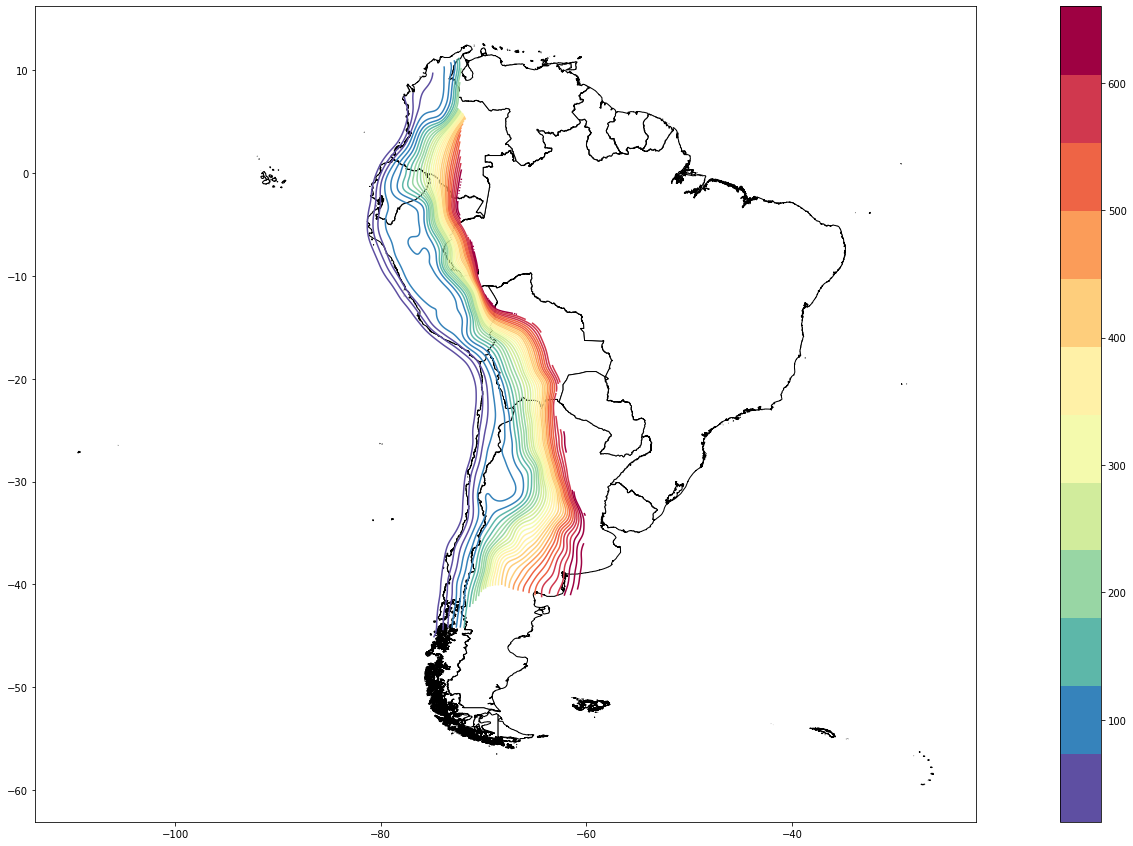

In [9]:
# Plotting the South American continent and the depths of the slab

fig, ax = plt.subplots(figsize=(30,15))
ax.set_aspect('equal')

america.plot(ax=ax,color='white', edgecolor='black')

#gdf_depth.sort_values("Depth").plot(ax=ax,column='Depth', cmap=plt.cm.get_cmap('Spectral', 12), legend=True)

# The contours offer a better visualization than the grid

depth_contour.plot(ax=ax, column="DEPTH", cmap=plt.cm.get_cmap('Spectral_r', 12), legend = True)

Now we are coming to the depth calculation. Scipy.interpolate.griddata can do the job.
We just have to plug in our coordinates as an 2darray and it will interpolate the depth for each point.

In [10]:
# Creating the ndarray for the coordinates of the volcanoes

coordinates = volcanoes[["Longitude", "Latitude"]].values

In [11]:
# The function is interpolating the depths from the slab2 dataset for our coordinates 

points_depth = df[["Longitude", "Latitude"]].values
values_depth = df[["Depth"]].values
result_depths = griddata(points_depth, values_depth, coordinates, method="cubic")

In [12]:
# Add the depths to our dataframe

volcanoes["Depth"] = result_depths

In [13]:
# Create a GeoDataFrame for the volcanoes

gdf_volcanoes = gpd.GeoDataFrame(volcanoes, geometry = [geo.Point(x,y) for x,y in zip(volcanoes.Longitude, volcanoes.Latitude)])

In [14]:
# Filter all the volcanoes that are not on the slab

gdf_volcanoes = gdf_volcanoes[np.isfinite(gdf_volcanoes['Depth'])]

In [15]:
# Save our results to pickle

gdf_volcanoes.to_pickle('./data/gdf_volcanoes')